In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
from datetime import datetime, date, time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmasher as cmr

from mpl_toolkits.basemap import Basemap
pd.set_option('max_columns', None)
from netCDF4 import Dataset
from pathlib import Path
from dateutil.relativedelta import *

#### [1] Data figure

In [2]:
def zos_LoadData(np,Dataset,Path,df,nsim,disp_flag):
    
    #[1] Information of zos file (e.g., EC-Earth3P_hist-1950_r1i1p2f1.nc)
    #path=(r'\\wsl$/Ubuntu-20.04/home/aelshall/NCO/FLmap/zos/260W285S_17S35N/data/')
    path='Input/'
    file='{}_{}_{}.nc'.format(df.loc[nsim, 'Source_ID'],df.loc[nsim, 'Experiment_ID'],df.loc[nsim, 'Variant_Label'])
    #print(file)
    realization=df.loc[nsim, 'Variant_Label']
    if disp_flag>0:
        print('{}: {}'.format(df.loc[nsim,'Institution_ID'],file))
    
    #[2] Read netCDF file
    #(2.1) Load netCDF file 
    data= Dataset(path+file,'r')  
    if disp_flag>1:
        print('reading netCDF file:')
        print(path+file)

        #(2.2) Read netCDF data infromation 
        #print "meta data for the dataset:"
        #print(data)
        #print('')
        print('List of variables:')
        print(data.variables.keys())
        print('')


    #[3] Read lat and lon data
    #(3.1) Name of lat and lon dimension variable 
    if df.loc[nsim,'lat_lon_grid']== 'no':
        lat_ID=df.loc[nsim,'lat_1d_ID']
        lon_ID=df.loc[nsim,'lon_1d_ID']
    else:
        lat_ID=df.loc[nsim,'lat_grid_ID']
        lon_ID=df.loc[nsim,'lon_grid_ID']
    
    #(3.2) Read lat and lon data from netCDF variables
    lats=data.variables[lat_ID][:]    #-89.5 to  89.5
    lons=data.variables[lon_ID][:]    #  0.5 to 359.
    if disp_flag>1:
        print('lats dimensions {}'.format(lats.shape))
        print('lons dimensions {}'.format(lons.shape))
        
        if disp_flag>2:
            print('native latitude coordinates:')
            if lats.ndim>1:
                print(lats[:,1])
            else:
                print(lats)
            print('')

            print('native longitude coordinates:')
            if lons.ndim>1:
                print(lons[1,:])
            else:
                print(lons)
            print('')

    #(3.3) lon conversion from 0:360 to 0:180E and 0:-180W with 0 greenwich prime meridian
    lons[:][lons[:]>180]-=360
    if disp_flag>2:
        print("Convert longitude '180:360' to '-180:0' if required:")
        if lons.ndim>1:
            print(lons[1,:])
        else:
            print(lons)
        print('')
        print('type of lats and lons data:', type(lons))


    #[4] Read zos data 
    #(4.1) Check variable information
    vnam='zos'
    var=data.variables[vnam]
    if disp_flag>2:
        print('Meta data for',vnam, 'variable:')
        print(var)
        print(var.units)
        print('')

    #(4.2) Extract raw zos data
    vval=var[:]
    if disp_flag==2:
        print('vval dimensions {}'.format(vval.shape))
    elif disp_flag>1:
        print('variable data information:')
        print('type : ', type(vval))
        print('ndim : ', vval.ndim)
        print('shape: ', vval.shape)
        print('size : ', vval.size)
        print('size : ', vval.min())
        print('size : ', vval.max())
        
    return lats,lons,vval,data,vnam


In [3]:
def zos_GeoPlot(np,Dataset,Path,date,relativedelta,ax,nsim,start,title,Lim,cmap,nfig,Flag):

    #[0] General
    disp_flag=0
    Shading='gouraud' #none, flat, gouraud
    
    #[0]Variables 
    
    df=pd.read_csv('Input/zos_models.csv')
    lat_lon_grid=df.loc[nsim, 'lat_lon_grid']
    Source_ID=df.loc[nsim,'Source_ID']
    Institution_ID=df.loc[nsim,'Institution_ID']
    Experiment_ID=df.loc[nsim,'Experiment_ID']
    Variant_Label=df.loc[nsim,'Variant_Label']

    #[1] load data
    lats,lons,vval,data,vnam=zos_LoadData(np,Dataset,Path,df,nsim,disp_flag)
    if disp_flag>1:
        print('vval dimensions {} with min,max=({},{})'.format(vval.shape,str(vval.min()),str(vval.max())))
        print('grid type: ' + lat_lon_grid)
    
    #[2] Select zos data period
    #Time range 199001 to 201412

    #(3.1) Select Basemap
    #(3.2) Draw and label meridians (longitude lines) for values (in degrees) given in the sequence meridians
    #(3.3) Lon and lat data, and mesh grid 
    if lat_lon_grid == 'no':
        lon, lat= np.meshgrid(lons,lats) #Creat mesh grid
    else:
        lon,lat=lons,lats
    x,y=ax.map(lon,lat) #x, y coordiante

    #(3.4) Extract zos data
    val=vval[start,:,:]

    #(3.5) plot zos data
    if Source_ID== 'CESM1-CAM5-SE-HR':
        val[x==1e20]=np.nan
        val[y==-1]=np.nan
        x[x==1e20]=np.nan
        y[y==-1]=np.nan
        ax.map.pcolor(x,y,np.squeeze(val), cmap='jet',zorder=7) 
    elif Institution_ID== 'MPI-M':
        ax.map.pcolor(x,y,np.squeeze(val), cmap='jet',zorder=7) 
    else:
        ax.map.pcolormesh(x,y,np.squeeze(val), shading=Shading, cmap=cmap,zorder=10)   
    
    #(3.6) Colorbar
    if Flag==1:
        clb=ax.map.colorbar(location='bottom', pad='15%')
        clb.ax.tick_params(labelsize=16) 
        clb.ax.set_title('Sea surface height above geoid (zos) [m]',fontsize=16)

    #(3.7) Draw background 
    #(3.8) Title  
    if Flag==1:
        plt.title(title, pad=15,fontsize=18)
    else:
        if ((nfig== 0) or (nfig== 1)):
            plt.title(title,fontsize=15,pad=5)

    #plt.clim(-0.91,0.86)
    #plt.clim(vval.min(),vval.max())
    plt.clim(Lim[0],Lim[1])
        
    return ax

B-300 (9,22) and B-300 (59,78) north and south segments with 14 and 20 cells, respectively


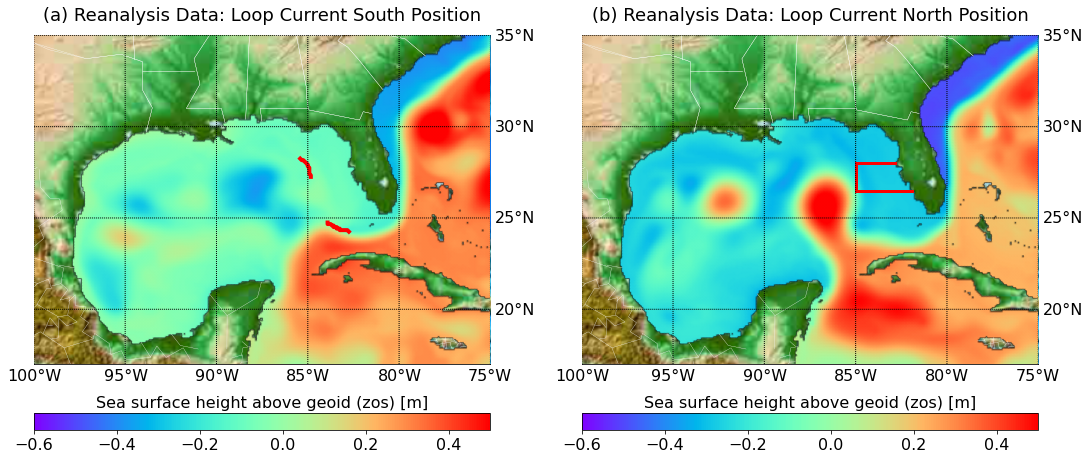

In [4]:
##### [1] Display processed results
#Section information (KB_Data_ESM)
#m=loadmat('zos_data_B300/Optimization/R3210.mat')
m=loadmat('Input/zos_data_B300_segments.mat')

ndata = {n: m['row'][n][0,0] for n in m['row'].dtype.names}
dfm=pd.DataFrame.from_dict(dict((column, ndata[column][0]) for column in [n for n, v in ndata.items() if v.size == 1]))
#display(dfm)

#display(dfm)
NSeg=dfm['N'][0]; ns=dfm['Nstr'][0]; ne=dfm['Nend'][0];SSeg=dfm['S'][0]; ss=dfm['Sstr'][0]; se=dfm['Send'][0];
print('{} ({},{}) and {} ({},{}) north and south segments with {} and {} cells, respectively'.format(NSeg,ns,ne,SSeg,ss,se,ne-ns+1,se-ss+1))

#[2] Create new figure
fig=plt.figure(figsize=(18,12))

#[3] Parameters per plot
Title=['(a) Reanalysis Data: Loop Current South Position','(b) Reanalysis Data: Loop Current North Position']
NFig=[1,2]
Start=[70,60]       #S(70,212) N(18,60) 
Lim=[-0.6,0.5]
cmap='rainbow'  

#[4] Plot figurefor nfig,Start,title in zip(NFig,NStart,Title):
for nfig, start,title in zip(NFig,Start,Title):
    #(1) Create subplot
    ax=fig.add_subplot(1,2,nfig)
    ax.map =Basemap(projection='cyl', llcrnrlon=-100.0, llcrnrlat=17.0, urcrnrlon=-75.0, urcrnrlat=35.0)
    ax.map.drawmeridians(np.arange(10.,351.,5.) ,labels=[False,False,False,True],fontsize=16,zorder=21)  
    ax.map.drawparallels(np.arange(0.,81,5.),labels=[False,True,False,False],fontsize=16,zorder=22) 
#     ax.map =Basemap(projection='cyl', llcrnrlon=-86.0, llcrnrlat=24.0, urcrnrlon=-82.0, urcrnrlat=29.0)
#     ax.map.drawmeridians(np.arange(10.,351.,0.1) ,labels=[False,False,False,True],fontsize=16,zorder=21)  
#     ax.map.drawparallels(np.arange(0.,81,0.1),labels=[False,True,False,False],fontsize=16,zorder=22) 
    
    #Additional things
    ax.map.drawstates(zorder=14,color='white',linewidth=0.3)
    ax.map.etopo(zorder=5)

    #(2) Plot segments 
    if nfig==1:
        data=np.loadtxt('Input/zos_data_B300.csv',delimiter=',')
        ax.map.plot(data[ns:ne,1], data[ns:ne,0], marker=None,color='r',linewidth=4,zorder=20)
        ax.map.plot(data[ss:se,1], data[ss:se,0], marker=None,color='r',linewidth=4,zorder=20)

    #(4) Plot site area
    if nfig==2:
        ax.map.plot([-85.0,-85.0],[26.5,28.0], marker=None,color='r',linewidth=3,zorder=20)
        ax.map.plot([-85.0,-82.85],[28.0,28.0], marker=None,color='r',linewidth=3,zorder=20)
        ax.map.plot([-85.0,-81.9],[26.5,26.5], marker=None,color='r',linewidth=3,zorder=20)
    
    #(5) Plot zos
    #(22) CMIP6.obs4MIPs.CMEMS.AVISO-1-0.phy-001-031.r0.Omon.zos.gn (1 realization) [86]
    nsim=86;
    Flag=1
    ax=zos_GeoPlot(np,Dataset,Path,date,relativedelta,ax,nsim,start,title,Lim,cmap,nfig,Flag)


#[5] Display or save plot
Save=1
if Save==0:
    plt.show()
elif Save==1:
    plt.savefig('Output/Figure1_Data.tif',bbox_inches='tight')

#### [2] Physcial phenomena figure

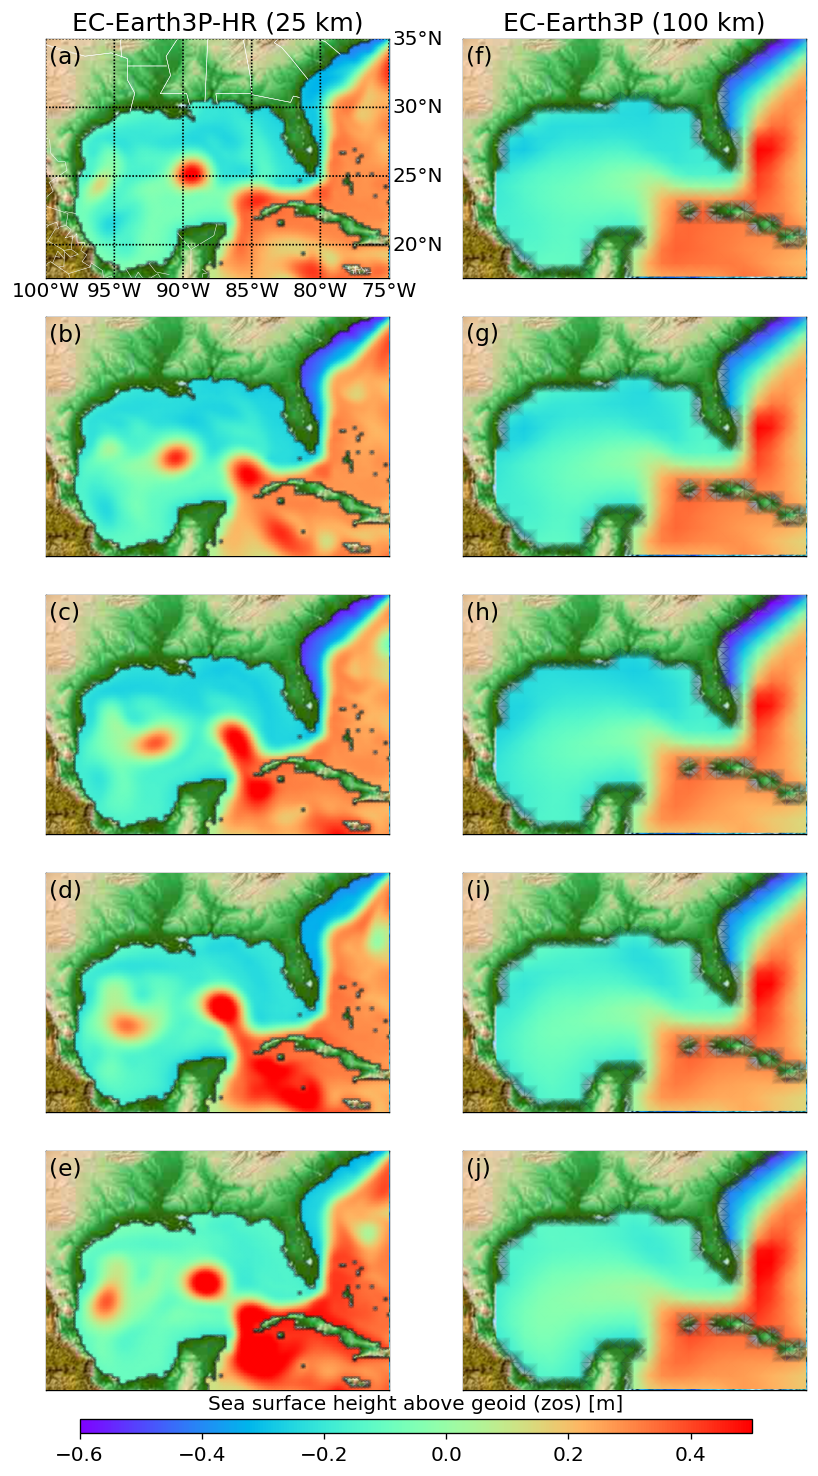

In [5]:
#[1] Select period
#Snap-shot from 2010-03 to XXXX-XX
First=1
Start=np.array([*range(First,First+5)]).repeat(2)  
npm=int(len(Start)/2)                              #Number of subplots per model
Ann=['(a)','(f)','(b)','(g)','(c)','(h)','(d)','(i)','(e)','(j)']

#[2] Figure general
NFig=range(npm*2)
fig=plt.figure(figsize=(7,12),dpi=120)

#[3] Select models 
Title=['EC-Earth3P-HR (25 km)','EC-Earth3P (100 km)']*npm
#[23] CMIP6.HighResMIP.EC-Earth-Consortium.EC-Earth3P-HR.hist-1950.r1i1p2f1.Omon.zos.gn
#[26] CMIP6.HighResMIP.EC-Earth-Consortium.EC-Earth3P.hist-1950.r2i1p2f1.Omon.zos.gn
NSim=np.array([26,23])
NSim=np.tile(NSim,(npm,1)).flatten()

#[4] Enhance visual effect
Lim=[-0.6,0.5]
cmap='rainbow'

#[5] Plot figure
for nfig,nsim,start,title,ann in zip(NFig,NSim,Start,Title,Ann):    
    #(1) Create subplot
    ax=fig.add_subplot(5,2,nfig+1)
    ax.map =Basemap(projection='cyl', llcrnrlon=-100.0, llcrnrlat=17.6, urcrnrlon=-75.0, urcrnrlat=35.0)
    if (nfig== 0):
        ax.map.drawmeridians(np.arange(10.,351.,5.) ,labels=[False,False,False,True],zorder=21,fontsize=12,color='k')  
        ax.map.drawparallels(np.arange(0.,81,5.),labels=[False,True,False,False],zorder=22,fontsize=12,color='k') 
        ax.map.drawstates(zorder=14,color='white',linewidth=0.3)

    ax.map.etopo(zorder=5)
    #ax.map.shadedrelief(zorder=5)
    #ax.map.fillcontinents(color='darkgray',lake_color='aqua',zorder=11)
    #ax.map.drawcoastlines(zorder=13)
    ax.annotate(ann, xy=(0.01, 0.9), xycoords='axes fraction',fontsize=14,zorder=14)


    #(5) Plot zos
    Flag=0
    ax=zos_GeoPlot(np,Dataset,Path,date,relativedelta,ax,nsim,start,title,Lim,cmap,nfig,Flag)


plt.tight_layout()
plt.subplots_adjust(bottom=0.03)
cax = plt.axes([0.1, 0, 0.8, 0.01]) #Left,bottom, length, width
clb=plt.colorbar(cax=cax,orientation="horizontal")
clb.ax.tick_params(labelsize=12) 
clb.ax.set_title('Sea surface height above geoid (zos) [m]',fontsize=12)
plt.savefig('Output/Figure2_SnapShot{}.tif'.format(First),bbox_inches='tight')